# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries for feature engineering
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql.functions import from_unixtime
from pyspark.sql.types import DateType
from pytz import timezone
from matplotlib import pyplot as plt

import datetime
import pyspark.sql.functions as f
import numpy as np

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load dataset from .json file

stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# For testing: Possibly subset dataset to increase speed

#df=df.limit(1000)

In [5]:
# Filter out entries without userId, i.e. where user cannot be identified (because he is not logged in)

df=df.where(df.userId!="")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [6]:
# Churn event

# Add column for churn event
# Churn event = "Cancellation Confirmation"
isChurnEvent=f.udf(lambda x: 1 if (x=="Cancellation Confirmation") else 0, IntegerType() )
df=df.withColumn("churn", isChurnEvent(df.page))

# Add column for churn users
# A churn user is a user with at least one churn event
userWin=Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df=df.withColumn("churnUser", f.sum(df.churn).over(userWin))

In [7]:
# Operating system
# Extracts operating system of column userAgent

def getOSOfStr(str1):
    """
    Checks if str1 contains label of an operating system 
    and returns it.
    """
    if str1 == None:
        return np.NaN
    
    if "Mac OS" in str1: 
        return "Mac OS"
    elif "iPhone OS" in str1:
        return "iOS"
    elif "Windows NT 5.1" in str1:
        return "Windows XP"
    elif "Windows NT 6.0" in str1:
        return "Windows Vista"
    elif "Windows NT 6.1" in str1:
        return "Windows 7"
    elif "Windows NT 6.2" in str1:
        return "Windows 8"
    elif "Windows NT 6.3" in str1:
        return "Windows 8.1"
    elif "Ubuntu" in str1:
        return "Ubuntu"
    elif "Linux" in str1:
        return "Linux"
    else:
        return np.NaN

getOS=f.udf(lambda x: getOSOfStr(x), StringType())
df=df.withColumn("OS", getOS(df.userAgent))

In [8]:
# Browser
# Extracts used browser of column userAgent

def getBrowserOfStr(str1):
    """
    Checks if str1 contains a browser name
    and returns it.
    """
    if str1 == None:
        return np.NaN
    
    if "Safari" in str1:
        if "Chrome" in str1:
            return "Chrome"
        else:
            return "Safari"
    elif "Firefox" in str1:
        return "Firefox"
    elif "Trident" in str1:
        return "Internet Explorer"
    else:
        return np.NaN
    
getBrowser=f.udf(lambda x: getBrowserOfStr(x), StringType())
df=df.withColumn("Browser", getBrowser(df.userAgent))

In [9]:
# State
# Extracts state name out of the string in column 'location'

def getStateOfStr(str1):
    """
    Subsets str1 and gives back the name of the state.
    """
    if str1 == None:
        return np.NaN
    
    commaPos=str1.rindex(",")
    rightSubstr=str1[commaPos+1:]
    return rightSubstr.strip()

getState=f.udf(lambda x: getStateOfStr(x), StringType())
df=df.withColumn("State", getState(df.location))

In [10]:
# Add column with readable date of event
convertToDate=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).date().isoformat())
df=df.withColumn("readableDate", convertToDate(df.ts))

In [11]:
# Add column with readable time of event
convertToTime=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).time().isoformat())
df=df.withColumn("readableTime", convertToTime(df.ts))

In [12]:
# Add column with weekday of event, coded as isoweekday, i.e. Monday=1, Tuesday=2, ...
convertToWeekday=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).date().isoweekday(), IntegerType())
df=df.withColumn("weekday", convertToWeekday(df.ts))

In [13]:
# Add column with hour of the day
# As the locations of the entries in our dataset all are in the U.S., we use time zone 'US/Central' (simplification)
ourTimezone="US/Central"
getHour=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0)
              .astimezone(timezone(ourTimezone)).time().hour, IntegerType())
df=df.withColumn("hour", getHour(df.ts))

In [14]:
# Add column with day of the year
getDayOfYear=f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).timetuple().tm_yday, IntegerType())
df=df.withColumn("dayOfYear", getDayOfYear(df.ts))

In [15]:
df.cache().count()

278154

In [16]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- churnUser: long (nullable = true)
 |-- OS: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- State: string (nullable = true)
 |-- readableDate: string (nullable = true)
 |-- readableTime: string (nullable = true)
 |-- weekday: integer (nullable

In [17]:
# Convert dataset

# In the following cells, we build a new dataset df_users containing churn-relevant data per user.
# The original dataset 'df', which contains the event trace over the whole time period, is used as basis here

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024869604C10>]],
      dtype=object)

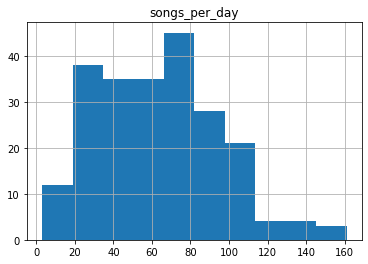

In [18]:
# Analyze average number of songs per day
songs_per_day=df.where(df.page=="NextSong").groupby("userId", "dayOfYear").count().sort("userId", "dayOfYear")
songs_per_day_user=songs_per_day.groupby("userId").agg({"count": "avg"}).select("userId", f.round("avg(count)", 0).alias("songs_per_day"))
songs_per_day_user.select("songs_per_day").toPandas().hist()
# -> Doesn't have much meaning if evaluated over whole interval because it's clear that churned users hear less songs per day 
# after they churned
# -> It's reasonable to calculate additional features only for period before churn event

In [19]:
# Initialize df_users with categorical features of dataframe df
df_users=df.select("userId", "gender", "Browser", "OS", "State", "churnUser").dropDuplicates(["userId"])

In [20]:
# Add column for day of first churn action
dayOfFirstChurn=df.filter(df.page=="Cancellation Confirmation") \
.select("userId", "dayOfYear").groupby("userId").agg({"dayOfYear":"min"}) \
.withColumnRenamed("min(dayOfYear)", "dayOfFirstChurn")

df_users=df_users.join(dayOfFirstChurn, on=["userId"], how="left")

In [21]:
# Add column for number of days of usage
# (i.e. number of days of usage of the Sparkify service between minimum date of dataset and day of churn event (per user))
# (used for mean calculation in the following cells)

min_ts=df.agg(f.min("ts")).collect()[0][0]
max_ts=df.agg(f.max("ts")).collect()[0][0]

min_date = datetime.datetime.fromtimestamp(min_ts/1000.0)
max_date = datetime.datetime.fromtimestamp(max_ts/1000.0)
minDayOfYear=min_date.timetuple().tm_yday
maxDayOfYear=max_date.timetuple().tm_yday

usageDays=f.udf(lambda x: (x-minDayOfYear+1) if x is not None else maxDayOfYear-minDayOfYear+1 , IntegerType())
df_users=df_users.withColumn("usageDays", usageDays(df_users.dayOfFirstChurn))

In [22]:
# Add column for number of songs per day / per user before churn event

# per user, mark the rows before and after churn action
df.createOrReplaceTempView("df")

period_table = spark.sql('''
    SELECT *, MAX(churn) OVER
    (PARTITION BY userID ORDER BY dayOfYear ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period
    FROM df
    ''')

# keep the results in a view
period_table.createOrReplaceTempView("period_table")

# find the average count for NextSong
songsBeforeChurn=spark.sql('''
        SELECT userID, COUNT(*) AS songsBeforeChurn FROM period_table
        WHERE period = 0 AND page = 'NextSong'
        GROUP BY userID
        ''')

df_users=df_users.join(songsBeforeChurn, on=["userId"], how="left")
df_users=df_users.withColumn("songsPerDayBeforeChurn", (df_users.songsBeforeChurn / df_users.usageDays)).drop("songsBeforeChurn")

In [23]:
# Add column for number of "Thumbs up" per day / per user before churn event

# find the average count for Thumbs Up
thumbsUpBeforeChurn=spark.sql('''
        SELECT userID, COUNT(*) AS thumbsUpBeforeChurn FROM period_table
        WHERE period = 0 AND page = 'Thumbs Up'
        GROUP BY userID
        ''')

df_users=df_users.join(thumbsUpBeforeChurn, on=["userId"], how="left")
df_users=df_users.withColumn("thumbsUpPerDayBeforeChurn", (df_users.thumbsUpBeforeChurn / df_users.usageDays)).drop("thumbsUpBeforeChurn")

In [24]:
# Add column for number of "Errors" per day / per user before churn event

# find the average count for errors
errorsBeforeChurn=spark.sql('''
        SELECT userID, COUNT(*) AS errorsBeforeChurn FROM period_table
        WHERE period = 0 AND page = 'Error'
        GROUP BY userID
        ''')

df_users=df_users.join(errorsBeforeChurn, on=["userId"], how="left")
df_users=df_users.withColumn("errorsPerDayBeforeChurn", (df_users.errorsBeforeChurn / df_users.usageDays)).drop("errorsBeforeChurn")

In [25]:
# Add column for number of "Help" per day / per user before churn event

# find the average count for help page accesses
helpBeforeChurn=spark.sql('''
        SELECT userID, COUNT(*) AS helpBeforeChurn FROM period_table
        WHERE period = 0 AND page = 'Help'
        GROUP BY userID
        ''')

df_users=df_users.join(helpBeforeChurn, on=["userId"], how="left")
df_users=df_users.withColumn("helpPerDayBeforeChurn", (df_users.helpBeforeChurn / df_users.usageDays)).drop("helpBeforeChurn")

In [26]:
# Add column for number of different artists per day before churn event

artistsBeforeChurn=spark.sql('''
        SELECT userID, COUNT(*) AS artistsBeforeChurn FROM (
            SELECT DISTINCT userId, artist
            FROM period_table
            WHERE period=0 AND page = 'NextSong'
        )
        GROUP BY userID
        ''')

df_users=df_users.join(artistsBeforeChurn, on=["userId"], how="left")
df_users=df_users.withColumn("artistsPerDayBeforeChurn", (df_users.artistsBeforeChurn / df_users.usageDays)).drop("artistsBeforeChurn")

In [27]:
# Add column for average session length

temp1=df.groupby("userId", "sessionId").count()
avgSessionLength=temp1.groupby("userId").agg({"count":"avg"}).withColumnRenamed("avg(count)", "avgSessionLength")
df_users=df_users.join(avgSessionLength, on=["userId"], how="left")

In [28]:
# Add column for main hour of usage 

temp2=df.groupby("userId", "hour").count().sort("userId", "hour")
userWin=Window.partitionBy("userId")
primHourOfUsage=temp2.withColumn("maxCount", f.max(temp2["count"]).over(userWin))
primHourOfUsage=primHourOfUsage.where(primHourOfUsage["maxCount"]==primHourOfUsage["count"]).select("userId", "hour").dropDuplicates(["userId"]).withColumnRenamed("hour", "mainUsageHour")
df_users=df_users.join(primHourOfUsage, on=["userId"], how="left")

In [29]:
df_users.cache().count()

225

In [30]:
# Prepare df_users table for modelling

# Remove NANs and drop columns with intermediate values
df_users=df_users.drop("dayOfFirstChurn", "usageDays")
df_users=df_users.fillna(0, subset=["songsPerDayBeforeChurn", "thumbsUpPerDayBeforeChurn", 
                                    "errorsPerDayBeforeChurn", "helpPerDayBeforeChurn", "artistsPerDayBeforeChurn" ])

# Define categorical and numerical columns
categoricalColumns=["gender", "Browser", "OS", "State"]
numericalColumns=["songsPerDayBeforeChurn", "thumbsUpPerDayBeforeChurn", "errorsPerDayBeforeChurn", 
                  "helpPerDayBeforeChurn", "artistsPerDayBeforeChurn", "avgSessionLength", "mainUsageHour"]

# Create dummy variables for categorical features
def getDummies(df, columnNames):
    allExprs=df.columns
    for cName in columnNames:
        categ = df.select(cName).distinct().rdd.flatMap(lambda x:x).collect()
        exprs = [f.when(f.col(cName) == cat,1).otherwise(0).alias(str(cat).replace(" ", "_")) for cat in categ]
        allExprs=allExprs+exprs        
    df2 = df.select(allExprs)
    df2=df2.drop(*columnNames)
    return df2

df_users_2=getDummies(df_users, categoricalColumns)

# Replace '.' in column name of dummy variable
df_users_2=df_users_2.withColumnRenamed("Windows_8.1", "Windows_8_1")

categoricalDummyColumns = [col for col in df_users_2.columns if (col not in numericalColumns) 
                           and (col not in ["userId", "churnUser", "numColsAss", "scaledNumCols"])]

In [31]:
df_users_2.cache().count()

225

In [32]:
# Write backup data to file system

# df_users.toPandas().to_csv(r"./df_users.csv", header=True, index=False)
#df_users_2.write.save("testOutput.csv")

<ipython-input-33-111131ff680b>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  h = df_features_pd[numericalColumns].hist(ax=ax)


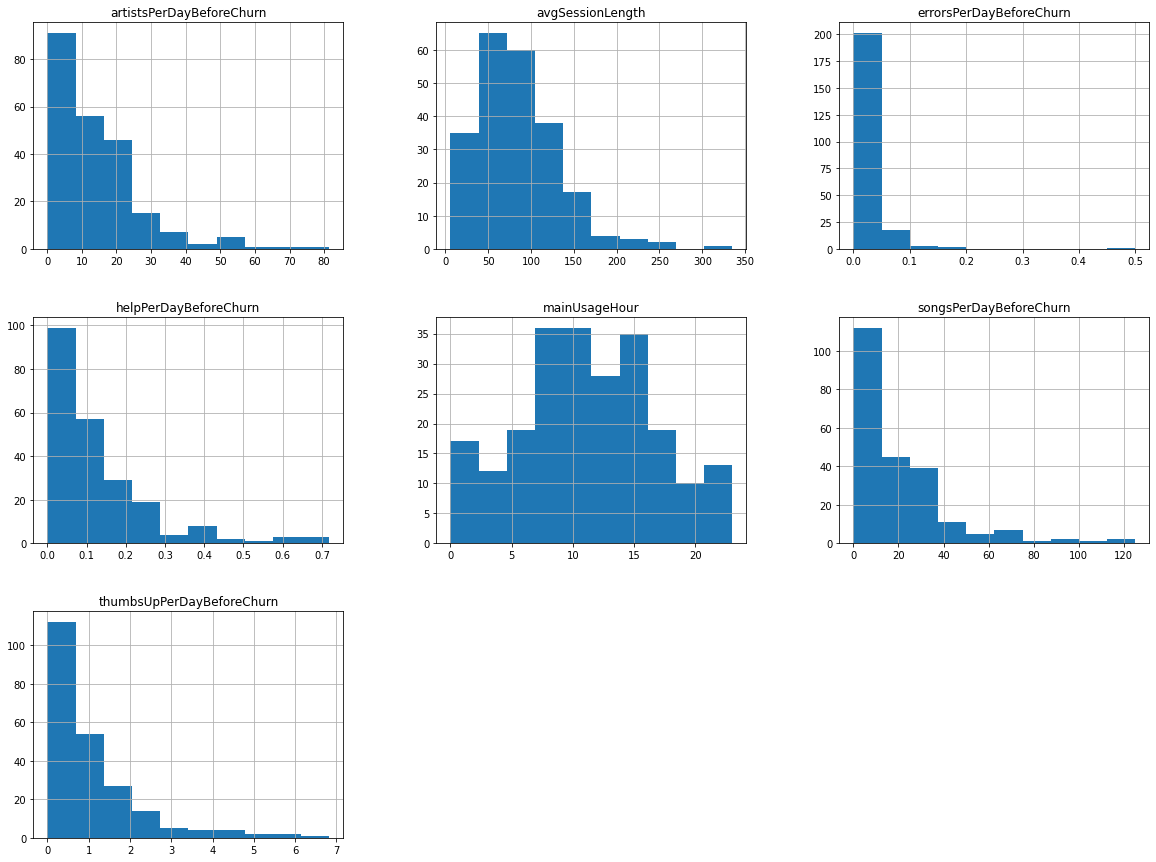

In [33]:
# Print histograms for the numerical features

df_features_pd=df_users_2.toPandas()
fig = plt.figure(figsize=(20,15))
ax = fig.gca()
h = df_features_pd[numericalColumns].hist(ax=ax)

In [44]:
df_users.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- State: string (nullable = true)
 |-- churnUser: long (nullable = true)
 |-- songsPerDayBeforeChurn: double (nullable = false)
 |-- thumbsUpPerDayBeforeChurn: double (nullable = false)
 |-- errorsPerDayBeforeChurn: double (nullable = false)
 |-- helpPerDayBeforeChurn: double (nullable = false)
 |-- artistsPerDayBeforeChurn: double (nullable = false)
 |-- avgSessionLength: double (nullable = true)
 |-- mainUsageHour: integer (nullable = true)



As the distributions of the numerical features seem very biased (i.e. non-normal), a standardization should be applied before training classification algorithms. Only 'mainUsageHour' will be excluded from standardization as this operation is meaningless here (due to cyclic scale). 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
# Import libraries for modelling

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

import pandas as pd

In [35]:
# Assemble and standardize/scale numerical features

numericalColumns.remove("mainUsageHour")
assemblerNumerical = VectorAssembler(inputCols=numericalColumns, outputCol="numColsAss")
df_user_3=assemblerNumerical.transform(df_users_2)
stdScaler = StandardScaler(inputCol="numColsAss", outputCol="scaledNumCols", withMean=True, withStd=True)
stdScalerModel=stdScaler.fit(df_user_3)
df_user_3_scaled=stdScalerModel.transform(df_user_3)

In [36]:
# Assemble all feature columns into one single column (for classification algorithms)

assemblerAll = VectorAssembler(inputCols=["scaledNumCols"]+["mainUsageHour"]+categoricalDummyColumns, outputCol="features")
df_user_4_scaled=assemblerAll.transform(df_user_3_scaled)
df_final=df_user_4_scaled.select(df_user_4_scaled.churnUser.alias("label"), df_user_4_scaled.features)

In [37]:
# Train-test-split

df_train, df_test = df_final.randomSplit([0.7, 0.3], seed=42)

In [38]:
# Function for training/testing of a classifier

def testClassifier(classifier, trainSet, testSet):
    '''
    Takes classifier, trains model on trainSet and tests it on testSet using MulticlassClassificationEvaluator
    Returns f1 score and accuracy for this classifier in a tuple.
    '''
    mcEvaluator= MulticlassClassificationEvaluator(predictionCol="prediction")    
    model = classifier.fit(trainSet)
    df_prediction = model.transform(testSet)
    f1_score=mcEvaluator.evaluate(df_prediction.select("label", "prediction"), {mcEvaluator.metricName: "f1"})
    accuracy_score=mcEvaluator.evaluate(df_prediction.select("label", "prediction"), {mcEvaluator.metricName: "accuracy"})
    return (f1_score, accuracy_score)


In [39]:
# Training of Classifiers

# Decision Tree Classifier
decTreeCl = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Gradient-boosted Tree Classifier
gradBoostTrCl = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Random Forest Classifier
randForCl = RandomForestClassifier(seed=42)

# Linear Regression
linRegCl = LinearRegression(maxIter=5, regParam=0.0, fitIntercept=False, solver="normal")

# Logistic Regression
logRegCl = LogisticRegression(maxIter=50)

# Linear Support Vector Machine
linSVCCl = LinearSVC(maxIter=10, regParam=0.1)

# Multilayer perceptron Classifier
layers = [79, 10, 5, 2]
mulLayPerCl = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

classifiers = [("DecisionTreeClassifier", decTreeCl),
               ("GBTClassifier", gradBoostTrCl),
               ("RandomForestClassifier", randForCl),
               ("LinearRegression", linRegCl),
               ("LogisticRegression", logRegCl),
               ("LinearSVC", linSVCCl), 
               ("MultilayerPerceptronClassifier", mulLayPerCl)]

# Trains/Tests the initialized classifiers and collects the results in a data frame
resultScores={}
for clName, classifier in classifiers:
    currResultScores={}
    f1_score, accuracy = testClassifier(classifier, df_train, df_test)
    currResultScores["F1_Score"]=f1_score
    currResultScores["Accuracy"]=accuracy
    resultScores[clName]=currResultScores
    
df_resultScores=pd.DataFrame(resultScores)

In [40]:
# Results of the classifier test

df_resultScores

,DecisionTreeClassifier,GBTClassifier,RandomForestClassifier,LinearRegression,LogisticRegression,LinearSVC,MultilayerPerceptronClassifier
F1_Score,0.625000,0.625000,0.620513,0.0,0.687439,0.669333,0.650667
Accuracy,0.666667,0.666667,0.733333,0.0,0.716667,0.733333,0.683333


The results table shows that the LogisticRegression classifier performs best on the given dataset (maximum F1 score and maximum accuracy value). 
We will continue the modelling by tuning the LogisticRegression classifier. 

The LogisticRegression classifier allows us to weight the single entities in training. As the training dataset is heavily imbalanced concerning churn, we will first calculate the proportions of churning (1) and not-churning (0) users and weight the entries correspondingly in an additional column. 

In [41]:
# Weighting/Balancing of train data
# Calculates percentage of 1 and 0 labels. As train dataset is heavily imbalanced, we create an additinonal column
# to account for this in the future training

train_size=df_train.select("label").count()
numPositives=df_train.select("label").where("label == 1").count()
numNegatives=train_size-numPositives
percentagePos=float(numPositives)/float(train_size)
percentageNeg=float(numNegatives)/float(train_size)

df_train_2=df_train.withColumn("classWeights", f.when(df_train.label == 1, percentageNeg).otherwise(percentagePos))

In [42]:
# Tuning of Logistic Regression

# Tunes the LogistcRegression classifier using a parameter grid. 
# For reliable results, 3-fold cross validation is used.

# As the number of necessary train- and test-cycles multiplies with the number of parameters and cross validation cycles, 
# a reduced parameter set is used for performance reasons. 

logRegCl = LogisticRegression(maxIter=50, labelCol="label", featuresCol="features", weightCol="classWeights")

# Parameter set
'''
paramGrid = ParamGridBuilder() \
    .addGrid(logRegCl.aggregationDepth, [2,3,5,8]) \
    .addGrid(logRegCl.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(logRegCl.fitIntercept, [True, False]) \
    .addGrid(logRegCl.maxIter, [10,100,1000]) \
    .addGrid(logRegCl.regParam, [0.1, 0.5, 2.0]) \
    .build()
'''

# Reduced parameter set
paramGrid = ParamGridBuilder() \
    .addGrid(logRegCl.aggregationDepth, [2,10]) \
    .addGrid(logRegCl.elasticNetParam, [0.0, 0.5]) \
    .build()

crossval = CrossValidator(estimator=logRegCl,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

# Training and prediction
logModel=crossval.fit(df_train_2)
df_prediction=logModel.transform(df_test)

# Evaluation of results
mcEvaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
f1_score=mcEvaluator.evaluate(df_prediction.select("label", "prediction"), {mcEvaluator.metricName: "f1"})
accuracy_score=mcEvaluator.evaluate(df_prediction.select("label", "prediction"), {mcEvaluator.metricName: "accuracy"})

print("Tuning results:")
print("Aggregation Depth: ", logModel.bestModel.getAggregationDepth())
print("Elastic Net Param: ", logModel.bestModel.getElasticNetParam())
print("F1 score of best model: ", f1_score)
print("Accuracy of best model: ", accuracy_score)
print("")
print("Tuning metrics: ", logModel.avgMetrics)

Tuning results:
Aggregation Depth:  2
Elastic Net Param:  0.0
F1 score of best model:  0.6506666666666667
Accuracy of best model:  0.6833333333333333

Tuning metrics:  [0.6997631621907247, 0.6997631621907247, 0.6997631621907247, 0.6997631621907247]


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.